In [1]:
!mkdir data_v2

In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import pandas as pd
from uuid import uuid4
import json
from tqdm import tqdm
from imgaug import augmenters as iaa

# Analyze microaneurysms area

In [3]:
def get_mask_area(mask_arr):
    blobs, number_of_blobs = ndimage.label(mask_arr)
    areas = []
    for i in range(1,number_of_blobs+1):
        mask_indices = np.where(blobs == i)
        areas.append(math.sqrt(len(mask_indices[0]))/2)
    return areas

In [3]:
files = [f for f in os.listdir("label_v2/microaneurysms") if not f.startswith(".")]

In [24]:
areas = []
for file in files:
    mask = np.array(Image.open(os.path.join("microaneurysms",file)))[:,:,0]
    areas.extend(get_mask_area(mask))

(array([62., 18.,  6.,  2.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([ 2.        ,  6.61456125, 11.22912249, 15.84368374, 20.45824499,
        25.07280623, 29.68736748, 34.30192873, 38.91648998, 43.53105122,
        48.14561247]),
 <a list of 10 Patch objects>)

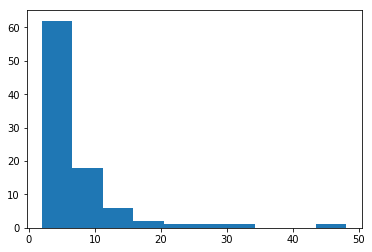

In [29]:
plt.hist(areas)

For microaneurysms, choosing the radius of 10 pixels

# Building data for MRCNN

In [4]:
data = pd.read_csv("label_v2/labels.csv", index_col=0)

In [5]:
data.head()

,filename,ID,phase,labeller,exudates,hemorrhage,microaneurysms
0,CTEH-000069.jpg,NaN,1,ntthoa@cthospital.vn,0,0,"[{'x': 1475.25, 'y': 881.5}, {'x': 1504.2, 'y'..."
1,CTEH-000135.jpg,NaN,1,ntthoa@cthospital.vn,1,0,"[{'x': 621.5, 'y': 917.375}, {'x': 750.875, 'y..."
2,CTEH-000172.jpg,NaN,1,ntthoa@cthospital.vn,0,1,NaN
3,CTEH-000200.jpg,NaN,1,ntthoa@cthospital.vn,1,0,"[{'x': 1944.8333333333333, 'y': 1187.5}, {'x':..."
4,CTEH-001700.jpg,NaN,1,nnquang@cthospital.vn,0,1,"[{'x': 1066.2, 'y': 582.4}, {'x': 1153.8571428..."


In [6]:
def convert_json(x):
    if type(x) != str and math.isnan(x):
        return []
    return json.loads(x.replace("'", '"'))
data['microaneurysms'] = data.microaneurysms.map(lambda x : convert_json(x))
data.head()

,filename,ID,phase,labeller,exudates,hemorrhage,microaneurysms
0,CTEH-000069.jpg,NaN,1,ntthoa@cthospital.vn,0,0,"[{'x': 1475.25, 'y': 881.5}, {'x': 1504.2, 'y'..."
1,CTEH-000135.jpg,NaN,1,ntthoa@cthospital.vn,1,0,"[{'x': 621.5, 'y': 917.375}, {'x': 750.875, 'y..."
2,CTEH-000172.jpg,NaN,1,ntthoa@cthospital.vn,0,1,[]
3,CTEH-000200.jpg,NaN,1,ntthoa@cthospital.vn,1,0,"[{'x': 1944.8333333333333, 'y': 1187.5}, {'x':..."
4,CTEH-001700.jpg,NaN,1,nnquang@cthospital.vn,0,1,"[{'x': 1066.2, 'y': 582.4}, {'x': 1153.8571428..."


In [7]:
def save_blobs(mask_arr, out_dir):
    blobs, number_of_blobs = ndimage.label(mask_arr)
    for i in range(1,number_of_blobs+1):
        out_file = os.path.join(out_dir, f"{uuid4()}.jpg")
        Image.fromarray(((blobs == i) * 255).astype(np.uint8)).save(out_file)

In [8]:
def generate_mask(x_center, y_center, mask_shape, out_dir):
    mask = np.zeros(mask_shape, dtype=np.uint8)
    min_y = max(0, y_center-np.random.randint(10,20))
    max_y = min(mask.shape[0], y_center+np.random.randint(10,20))
    min_x = max(0, x_center-np.random.randint(10,20))
    max_x = min(mask.shape[1], x_center+np.random.randint(10,20))
    mask[min_y:max_y, min_x:max_x] = 255
    out_file = os.path.join(out_dir, f"{uuid4()}.jpg")
    Image.fromarray(mask).save(out_file)

In [9]:
def square_crop(image_path, mask_paths):

    # Read image
    image = Image.open(image_path).convert('RGB')
    img = np.asarray(image)
    w, h = image.size
    mask = (img > 15)

    mask = mask[:,:,0] * mask[:,:,1] * mask[:,:,2] * 1.0

    one_mask = np.argwhere(mask == 1)
    max_pos = np.max(one_mask, axis=0)
    min_pos = np.min(one_mask, axis=0)
    top, bottom , left, right = min_pos[0], max_pos[0], min_pos[1], max_pos[1]
    img = img[top:bottom, left: right]

    h, w = img.shape[0], img.shape[1]
    size = h if w > h else w
    v_pad = (w > h) * (w-h)
    h_pad = (w < h) * (h-w)

    # Transform image
    val_seq = iaa.Sequential(
        [
            iaa.Pad(
                px=((int(v_pad/2), int(v_pad/2)), (int(h_pad/2), int(h_pad/2)), (int(v_pad/2), int(v_pad/2)),(int(h_pad/2), int(h_pad/2))),
                keep_size=False
            )
        ], random_order=False
    )
    img = val_seq.augment_image(img)
    im = Image.fromarray(img)
    im.save(image_path)
    
    for mask_path in mask_paths:
        image = Image.open(mask_path)
        img = np.asarray(image)
        img = img[top:bottom, left: right]
        img = val_seq.augment_image(img)
        im = Image.fromarray(img)
        im.save(mask_path)

In [77]:
for image_id in os.listdir("data"):
    if not image_id.startswith("."):
        image_path = f"data/{image_id}/images/{image_id}.jpg"
        mask_paths = []
        for lesion in os.listdir(f"data/{image_id}/masks"):
            if not lesion.startswith("."):
                parent_mask_dir = f"data/{image_id}/masks/{lesion}"
                for mask_path in os.listdir(parent_mask_dir):
                    if not mask_path.startswith(".") and mask_path.endswith(".jpg"):
                        mask_paths.append(os.path.join(parent_mask_dir, mask_path))
        square_crop(image_path, mask_paths)

FileNotFoundError: [Errno 2] No such file or directory: 'data/normal/masks'

In [72]:
for idx, row in tqdm(data.iterrows()):
    if row.exudates == 0 and row.hemorrhage and len(row.microaneurysms) == 0:
        continue
    data_dir = os.path.join("data", row.filename[:-4])
    !mkdir -p {data_dir}/images
    !mkdir -p {data_dir}/masks
    !cp ./images/{row.filename} {data_dir}/images
    if row.exudates == 1:
        !mkdir -p {data_dir}/masks/exudates
        mask = np.array(Image.open(os.path.join("exudates",row.filename)))[:,:,0]
        save_blobs(mask, f"{data_dir}/masks/exudates")
    if row.hemorrhage == 1:
        !mkdir -p {data_dir}/masks/hemorrhage
        mask = np.array(Image.open(os.path.join("hemorrhage",row.filename)))[:,:,0]
        save_blobs(mask, f"{data_dir}/masks/hemorrhage")
    if len(row.microaneurysms) > 0:
        !mkdir -p {data_dir}/masks/microaneurysms
        w,h = Image.open(f"./images/{row.filename}").size
        for point in row.microaneurysms:
            generate_mask(int(point['x']), int(point['y']), (h,w), f"{data_dir}/masks/microaneurysms")


0it [00:00, ?it/s]
1it [00:01,  1.19s/it]
2it [00:03,  1.49s/it]
4it [00:06,  1.50s/it]
5it [00:08,  1.72s/it]
6it [00:09,  1.52s/it]
7it [00:16,  2.99s/it]
8it [00:17,  2.53s/it]
9it [00:20,  2.62s/it]
10it [00:23,  2.83s/it]
11it [00:26,  2.89s/it]
12it [00:34,  4.33s/it]
13it [00:36,  3.49s/it]
14it [00:40,  3.85s/it]
15it [00:42,  3.14s/it]
16it [00:43,  2.67s/it]
17it [00:45,  2.29s/it]
18it [00:55,  4.67s/it]
19it [00:58,  4.17s/it]
20it [01:00,  3.69s/it]
21it [01:03,  3.41s/it]
22it [01:06,  3.16s/it]
23it [01:08,  2.84s/it]
24it [01:09,  2.46s/it]
25it [01:13,  2.66s/it]
26it [01:15,  2.47s/it]
27it [01:17,  2.48s/it]
28it [01:20,  2.50s/it]
29it [01:25,  3.23s/it]
30it [01:28,  3.43s/it]
31it [01:31,  3.08s/it]
32it [01:32,  2.65s/it]
34it [01:34,  2.05s/it]
35it [01:35,  1.72s/it]
36it [01:36,  1.54s/it]
37it [01:38,  1.63s/it]
38it [01:39,  1.63s/it]
39it [01:41,  1.72s/it]
40it [01:43,  1.87s/it]
41it [01:47,  2.50s/it]
42it [01:49,  2.35s/it]
43it [01:54,  3.01s/it]
44it